In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sb

Завантажуємо дані, ти дивимося на перші 5 рядків:

In [38]:
df = pd.read_csv('/content/gdrive/My Drive/task.csv', sep=';',  encoding = "ISO-8859-1")
df.head()

,Unnamed: 0,ISO,UA,Cql,Ie,Iec,Is
0,Albania,ALB,Àëáàí³ÿ,"0,97392353","0,605347614","0,538672856","0,510112666"
1,Algeria,DZA,Àëæèð,"0,782134498","0,58721932","0,348159396","0,497985576"
2,Angola,AGO,Àíãîëà,"0,372343539","0,27439361","0,332117384","0,346906645"
3,Argentina,ARG,Àðãåíòèíà,"0,883830062","0,699685109","0,28199471","0,518820368"
4,Armenia,ARM,Â³ðìåí³ÿ,"1,016498793","0,718326882","0,535647909","0,486498047"


Далі видалємо перші 3 колонки, вони нам не потрібні на даному етапі, якщо потім знадобляться, ми зможемо їх додати по індексу

In [39]:
df = df.drop(['Unnamed: 0', 'ISO', 'UA'], axis=1)
df.head()

,Cql,Ie,Iec,Is
0,"0,97392353","0,605347614","0,538672856","0,510112666"
1,"0,782134498","0,58721932","0,348159396","0,497985576"
2,"0,372343539","0,27439361","0,332117384","0,346906645"
3,"0,883830062","0,699685109","0,28199471","0,518820368"
4,"1,016498793","0,718326882","0,535647909","0,486498047"


Дивимося загальну інформацію по датасету:

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
Cql    132 non-null object
Ie     132 non-null object
Iec    132 non-null object
Is     132 non-null object
dtypes: object(4)
memory usage: 4.2+ KB


як бачимо, в нас 132 рядки, немає NaN-ів, проте є проблема, що тип даних - object, проблема зв'язана з python, він не розпізнає float, який розділений комою, наступна дія це пофіксить:

In [41]:
def f(raw):
  for j in range(len(raw)):
    raw[j] = float(str(raw[j]).replace(',', '.'))
  return raw

df = df.apply(f)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
Cql    132 non-null float64
Ie     132 non-null float64
Iec    132 non-null float64
Is     132 non-null float64
dtypes: float64(4)
memory usage: 4.2 KB


Як можемо побачити, тепер в нас тип даних float :)

Далі замінимо всі від'ємні значення, якщо такі є, на додатні:

In [0]:
def f_1(raw):
  for j in range(len(raw)):
    if raw[j] < 0:
      raw[j] = np.absolute(raw[j])
  return raw

df = df.apply(f_1)

Тепер побудуємо кореляційну матрицю:

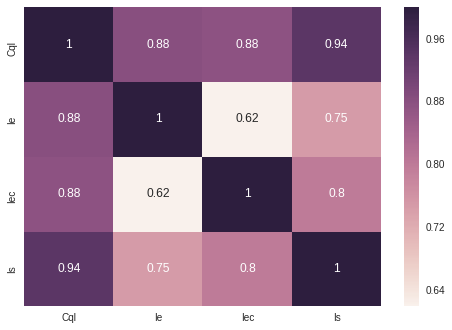

In [45]:
corr = df_1.corr()
sb.heatmap(corr, annot=True)

розіб'ємо дані на навчальну і тестову вибірки, таким чином, щоб тестова становила 20% від всіх даних

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Is',axis=1), 
                                                    df['Is'], test_size=0.20, 
                                                    random_state=101)

Спробуємо натренувати лінійну регресію

Для оцінки будемо використовувати метрику $R^2$


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [51]:
lr = LinearRegression(n_jobs=-1)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

0.9732314547130143

Як бачимо, отримали досить непоганий результат, бля перевірки його адекватності проведемо крос-валідацію:

In [85]:
scores = cross_val_score(lr, df.drop('Is', axis=1), df['Is'], scoring='r2', cv=5)
scores

array([0.96211109, 0.97732049, 0.96406087, 0.96860884, 0.94903708])

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [94]:
model = Pipeline([('poly', PolynomialFeatures(degree=5)), 
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
model = model.fit(X_train.iloc[:], y_train)
y_pred_p = model.predict(X_test)
r2_score(y_test, y_pred_p)

0.9986067235731338

In [0]:
from sklearn.model_selection import cross_val_score

In [95]:
scores_p = cross_val_score(model, df.drop('Is', axis=1), df['Is'], scoring='r2', cv=5)
scores_p

array([0.97489124, 0.99986188, 0.99856954, 0.9998344 , 0.99889621])